$$v(t, x) = 1 + u(t)w(x)$$

$$v(t) = 1 + u(t)w(x(t))$$

We will consider inhibitory weights ($w < 0$).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from disp import set_plot

cc = np.concatenate

RT = np.linspace(-.05, 1.05, 1001)
RX = np.linspace(-.05, 1.05, 1001)

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c='k') for x in xs]
    
    ax.xaxis.tick_bottom()
    set_plot(ax, x_label='t', y_label='x')

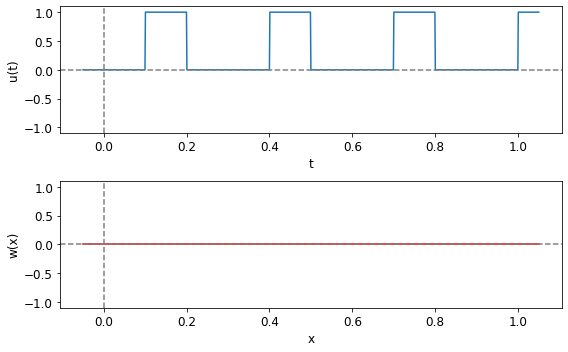

In [2]:
DT = .001
PER_T = .3
DUTY_T = 1/3
PER_X = .08
DUTY_X = .4
T_0 = .1
X_0 = 0 + PER_X - PER_X*DUTY_X

def u_fn(t_):
    sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
    return (sq_wv + 1)/2

W_SCALE_XPL = 0.001
w_xpl = -W_SCALE_XPL*np.ones(len(RX))

def w_fn(x_, w):
    idx = np.argmin(np.abs(x_-RX))
    return w[idx]

fig, axs = plt.subplots(2, 1, figsize=(8, 5), tight_layout=True)
axs[0].plot(RT, u_fn(RT))
set_plot(axs[0], x_label='t', y_label='u(t)')
axs[1].plot(RX, w_xpl, c='r')
set_plot(axs[1], x_label='x', y_label='w(x)')
for ax in axs:
    ax.axvline(0, color='gray', ls='--')
    ax.axhline(0, color='gray', ls='--')
    set_plot(ax, y_lim=(-1.1, 1.1))

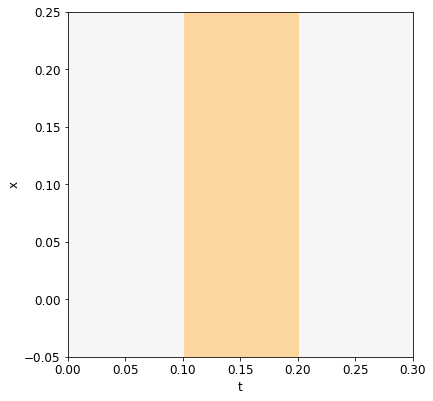

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plot_trj(ax, u_fn, w_xpl, cscale=.25/W_SCALE_XPL)
set_plot(ax, x_lim=(-0, .3), y_lim=(-.05, .25))

In [4]:
def smlt(x_0, t, u_fn, w):
    
    x = np.nan*np.zeros(len(t))
    u = np.nan*np.zeros(len(t))
    v = np.nan*np.zeros(len(t))
    
    x[0] = x_0
    u[0] = u_fn(0)
    v[0] = 1 + u[0]*w_fn(x_0, w)

    for ct, t_ in enumerate(t[1:], 1):
        u[ct] = u_fn(t_)
        v[ct] = 1 + u[ct]*w_fn(x[ct-1], w)
        x[ct] = x[ct-1] + DT*v[ct]
        
    return x, u, v

In [5]:
t = np.arange(0, .5, DT)
x_0s = np.array([-.01, 0., .01])
xs = []
us = []
vs = []

W_SCALE = 0.5
w = -W_SCALE*np.ones(len(RX))

for x_0 in x_0s:
    x, u, v = smlt(x_0, t, u_fn, w)
    xs.append(x.copy())
    us.append(u.copy())
    vs.append(v.copy())

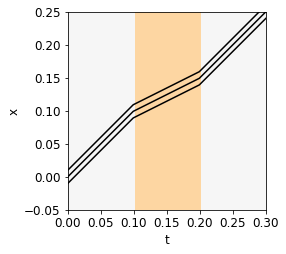

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
plot_trj(ax, u_fn, w, t, xs, cscale=.25/W_SCALE)
set_plot(ax, x_lim=(-0, .3), y_lim=(-.05, .25))

Plasticity of inhibitory modulation

In [7]:
def update_w(w, t, x, u, delta=0):
    # create "activation time-series"
    atvy = np.zeros((len(RX), len(t)))
    
    for ct, t_ in enumerate(t):
        iatv = np.argmin(np.abs(x[ct] - RX))
        if iatv < atvy.shape[0]:
            atvy[iatv, ct] = 1
        else:
            break
    
    # take time integral of each neuron's activation times shifted input
    ishift = int(np.round(delta/DT))
    u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = -.5
    
    # forgetting
    w_new[~mx] = -.1
    
    return w_new, atvy, mx

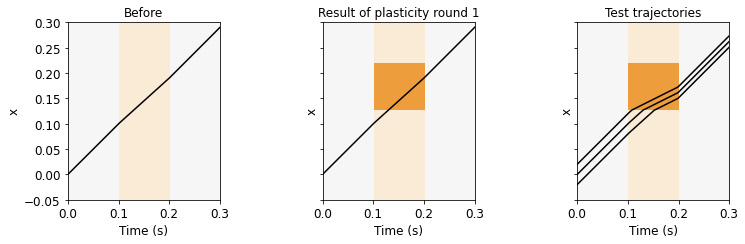

In [8]:
t = np.arange(0, .5, DT)
W_SCALE = 0.1
w = -W_SCALE*np.ones(len(RX))

x, u, v = smlt(0., t, u_fn, w)
w_new, atvy, mx = update_w(w, t, x, u, delta=.03)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True, sharey=True)
plot_trj(axs[0], u_fn, w, t, [x], cscale=.1/W_SCALE)
set_plot(axs[0], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .3), x_label='Time (s)', title='Before')

plot_trj(axs[1], u_fn, w_new, t, [x], cscale=.1/W_SCALE)
set_plot(axs[1], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .3), x_label='Time (s)', title='Result of plasticity round 1')

x_0s = np.array([-.02, 0, .02])
xs = [smlt(x_0, t, u_fn, w_new)[0] for x_0 in x_0s]
plot_trj(axs[2], u_fn, w_new, t, xs, cscale=.1/W_SCALE)
set_plot(axs[2], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .3), x_label='Time (s)', title='Test trajectories')

fig.savefig('ms/4_plasticity_demo_inh.svg')

Plasticity of excitatory modulation

In [9]:
def update_w(w, t, x, u, delta=0):
    # create "activation time-series"
    atvy = np.zeros((len(RX), len(t)))
    
    for ct, t_ in enumerate(t):
        iatv = np.argmin(np.abs(x[ct] - RX))
        if iatv < atvy.shape[0]:
            atvy[iatv, ct] = 1
        else:
            break
    
    # take time integral of each neuron's activation times shifted input
    ishift = int(np.round(delta/DT))
    if ishift > 0:
        u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
    else:
        u_shifted = cc([u[-ishift:], np.zeros(-ishift)])
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = .5
    
    # forgetting
    w_new[~mx] = .1
    
    return w_new, atvy, mx

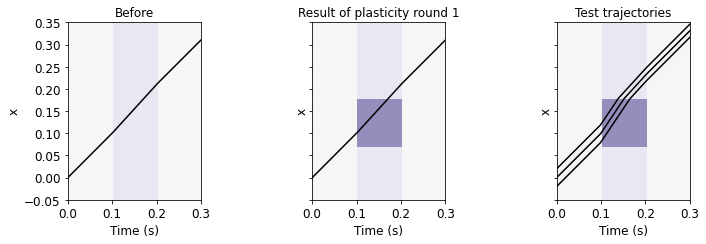

In [10]:
t = np.arange(0, .5, DT)
W_SCALE = 0.1
w = W_SCALE*np.ones(len(RX))

x, u, v = smlt(0., t, u_fn, w)
w_new, atvy, mx = update_w(w, t, x, u, delta=-.03)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True, sharey=True)
plot_trj(axs[0], u_fn, w, t, [x], cscale=.1/W_SCALE)
set_plot(axs[0], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .35), x_label='Time (s)', title='Before')

plot_trj(axs[1], u_fn, w_new, t, [x], cscale=.1/W_SCALE)
set_plot(axs[1], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .35), x_label='Time (s)', title='Result of plasticity round 1')

x_0s = np.array([-.02, 0, .02])
xs = [smlt(x_0, t, u_fn, w_new)[0] for x_0 in x_0s]
plot_trj(axs[2], u_fn, w_new, t, xs, cscale=.1/W_SCALE)
set_plot(axs[2], x_ticks=(0, .1, .2, .3), x_lim=(-0, .3), y_lim=(-.05, .35), x_label='Time (s)', title='Test trajectories')

fig.savefig('ms/4_plasticity_demo_exc.svg')

# Multiple rounds of plasticity

In [11]:
def update_w(w, t, x, u, delta=0):
    # create "activation time-series"
    atvy = np.zeros((len(RX), len(t)))
    
    for ct, t_ in enumerate(t):
        iatv = np.argmin(np.abs(x[ct] - RX))
        if iatv < atvy.shape[0]:
            atvy[iatv, ct] = 1
        else:
            break
    
    # take time integral of each neuron's activation times shifted input
    ishift = int(np.round(delta/DT))
    u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = -.5
    
    # forgetting
    w_new[~mx] = -.1
    
    return w_new, atvy, mx

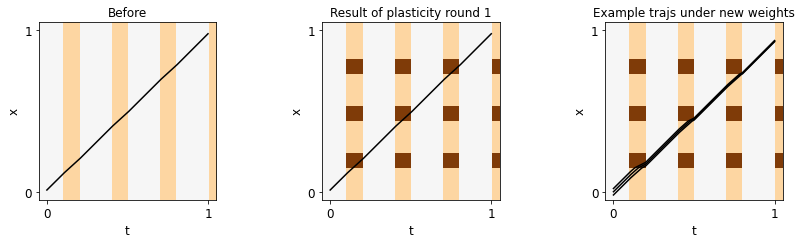

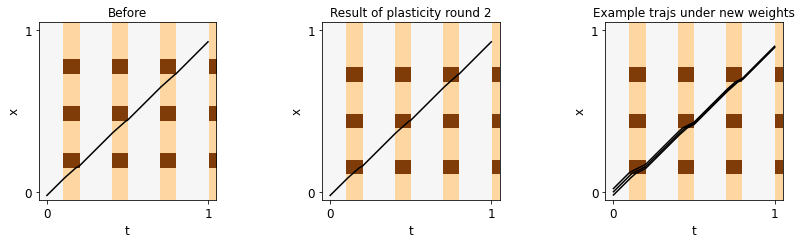

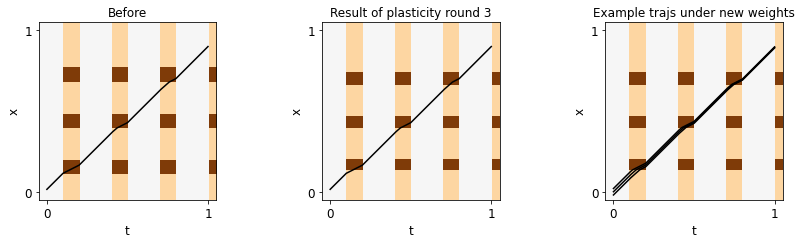

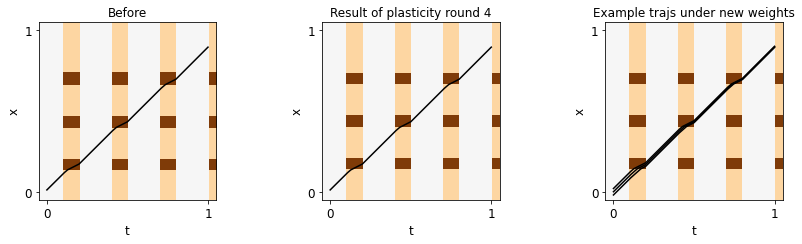

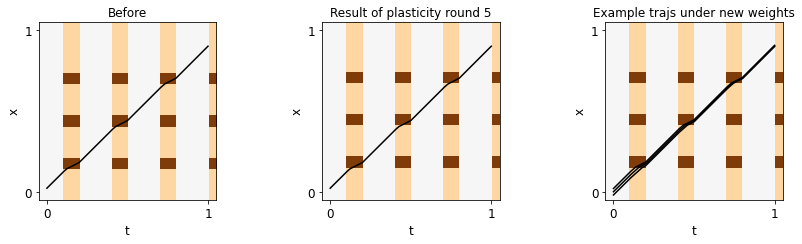

In [12]:
NROUND = 5
X_0S = np.array([-.02, 0, .02])
X_0_NOISE = .01

t = np.arange(0, 1., DT)

w = -.1*np.ones(len(RX))

for cround in range(NROUND):
    
    # x, u, v = smlt(0., t, u_fn, w)
    x, u, v = smlt(np.random.randn()*X_0_NOISE, t, u_fn, w)
    w_new, atvy, mx = update_w(w, t, x, u, delta=.04)

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
    plot_trj(axs[0], u_fn, w, t, [x], cscale=.25/W_SCALE)
    set_plot(axs[0], x_lim=(-0.05, 1.05), y_lim=(-.05, 1.05), title='Before')

    plot_trj(axs[1], u_fn, w_new, t, [x], cscale=.25/W_SCALE)
    set_plot(axs[1], x_lim=(-0.05, 1.05), y_lim=(-.05, 1.05), title=f'Result of plasticity round {cround+1}')

    xs = [smlt(x_0, t, u_fn, w_new)[0] for x_0 in x_0s]
    plot_trj(axs[2], u_fn, w_new, t, xs, cscale=.25/W_SCALE)
    set_plot(axs[2], x_lim=(-0.05, 1.05), y_lim=(-.05, 1.05), title='Example trajs under new weights')
    
    w = w_new